In [2]:
# Setup mlflow tracking
import mlflow
url = '127.0.0.1'
port = '8080'

mlflow.set_tracking_uri(uri=f"http://{url}:{port}")
print(f"MLflow tracking uri set to: {mlflow.get_tracking_uri()}")

MLflow tracking uri set to: http://127.0.0.1:8080


In [3]:
# Data processing
import datetime
import utils
import json

# Load API key
polygon_api_key = json.load(open('keys.json'))['POLYGON_API_KEY']

# Get min date
min_date = utils.get_max_date(file_dir='data/daily-aggregates')

# First time min date
# min_date = (datetime.datetime.now() - datetime.timedelta(days=5 * 365)).strftime('%Y-%m-%d')

# Download stock data
utils.update_stock_data(
    min_date=min_date.strftime('%Y-%m-%d'),
    max_date=datetime.datetime.now().strftime('%Y-%m-%d'),
    api_key=polygon_api_key
)

In [6]:
import pandas as pd

stock_df = utils.create_stock_dataframe(file_dir='data/daily-aggregates')
# Sort data by date
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.sort_values(by=['Date'], inplace=True, ascending=False)

# Save dataframe
stock_df.to_csv('data/stock_data/data.csv', index=False)

In [9]:
null_df = stock_df.groupby(['Date']).agg({'Transactions': lambda x: x.isnull().sum()})

null_df.reset_index(inplace=True)
null_df = null_df.rename(columns = {'index': 'Date'})

import plotly.express as px

fig = px.line(null_df, x='Date', y='Transactions')
fig.show()

In [10]:
null_df = stock_df.groupby(['Date']).agg({'Close_Price': lambda x: x.isnull().sum()})

null_df.reset_index(inplace=True)
null_df = null_df.rename(columns = {'index': 'Date'})

import plotly.express as px

fig = px.line(null_df, x='Date', y='Close_Price')
fig.show()

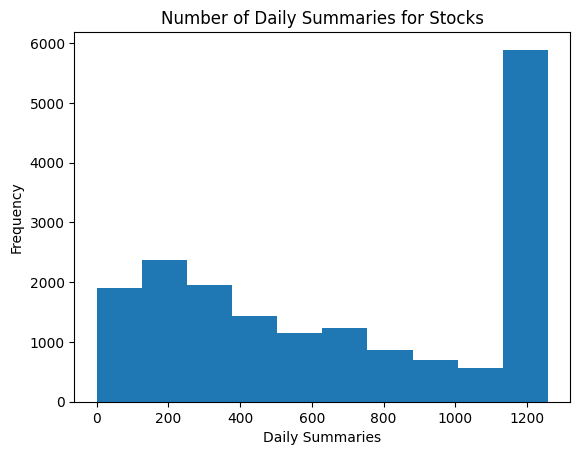

In [11]:
# Available summary data
from matplotlib import pyplot as plt

vals = stock_df.Exchange_Symbol.value_counts()
plt.hist(vals)
plt.title('Number of Daily Summaries for Stocks')
plt.xlabel('Daily Summaries')
plt.ylabel('Frequency')
plt.show()

In [7]:
import mlflow
import utils
import os
import json

import numpy as np
import pandas as pd

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from mlflow.models import infer_signature

# Load stock data if not already loaded
stock_df = pd.read_csv('data/stock_data/data.csv')
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Format data frame for forecasting
min_date = utils.get_min_date(file_dir='data/daily-aggregates')
max_date = utils.get_max_date(file_dir='data/daily-aggregates')
date_sequence = pd.date_range(start=min_date, end=max_date)
date_df = pd.DataFrame({'Date': date_sequence})

# Select stock to forecast
stock_symbol = 'GOOG'
temp_df = stock_df.loc[stock_df.Exchange_Symbol == stock_symbol]
temp_df = date_df.merge(temp_df, on='Date', how='left')
temp_df.fillna(method='ffill', inplace=True)

# Create a training, testing, and validation dataframe based on a forecasting window
forecast_window = 30
train_df = temp_df.loc[temp_df.Date < temp_df.Date.max() - pd.Timedelta(days=forecast_window * 2)]
test_df = temp_df.loc[temp_df.Date >= temp_df.Date.max() - pd.Timedelta(days=forecast_window)]
val_df = temp_df.loc[(temp_df.Date >= temp_df.Date.max() - pd.Timedelta(days=forecast_window * 2)) & (temp_df.Date < temp_df.Date.max() - pd.Timedelta(days=forecast_window))]

# Rename columns for modeling
forecast_metric = 'Close_Price'
train_df = train_df[['Date', forecast_metric]].rename(columns={"Date": "ds", 'Close_Price': "y"})
test_df = test_df[['Date', forecast_metric]].rename(columns={"Date": "ds", 'Close_Price': "y"})
val_df = val_df[['Date', forecast_metric]].rename(columns={"Date": "ds", 'Close_Price': "y"})

# Prophet model
prophet_model = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    seasonality_mode='multiplicative'
)
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=4)
prophet_model.add_seasonality('quarterly', period=91.25, fourier_order=8)

/var/folders/l8/z5qgtmlx6h99bqydyh6_8ksc0000gn/T/ipykernel_96964/3571568135.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_df.fillna(method='ffill', inplace=True)


In [11]:
with mlflow.start_run():
    prophet_model.fit(train_df)

    # extract and log parameters such as changepoint_prior_scale in the mlflow run
    model_params = {
        name: value for name, value in vars(prophet_model).items() if np.isscalar(value)
    }
    mlflow.log_params(model_params)

    # cross validate with 900 days of data initially, predictions for next 30 days
    # walk forward by 30 days
    cv_results = cross_validation(
        prophet_model, initial="900 days", period="30 days", horizon="30 days"
    )

    # Calculate metrics from cv_results, then average each metric across all backtesting windows and log to mlflow
    cv_metrics = ["mse", "rmse", "mape"]
    metrics_results = performance_metrics(cv_results, metrics=cv_metrics)
    average_metrics = metrics_results.loc[:, cv_metrics].mean(axis=0).to_dict()
    mlflow.log_metrics(average_metrics)

    # Calculate model signature
    train = prophet_model.history
    predictions = prophet_model.predict(prophet_model.make_future_dataframe(30))
    signature = infer_signature(train, predictions)

    model_info = mlflow.prophet.log_model(
        prophet_model, "prophet-model", signature=signature
    )

Exception: Prophet object can only be fit once. Instantiate a new object.

In [12]:
# Load saved model
prophet_model_saved = mlflow.pyfunc.load_model(model_info.model_uri)
val_df['floor'] = train_df['y'].min()
val_df['t'] = prophet_model_saved.predict(val_df)['trend']
val_df['y_scaled'] = val_df['y'] / val_df['t']
predictions = prophet_model_saved.predict(val_df)

MlflowException: Failed to enforce schema of data '             ds       y    floor
1764 2024-03-27  151.94  51.8115
1765 2024-03-28  152.26  51.8115
1766 2024-03-29  152.26  51.8115
1767 2024-03-30  152.26  51.8115
1768 2024-03-31  152.26  51.8115
1769 2024-04-01  156.50  51.8115
1770 2024-04-02  155.87  51.8115
1771 2024-04-03  156.37  51.8115
1772 2024-04-04  151.94  51.8115
1773 2024-04-05  153.94  51.8115
1774 2024-04-06  153.94  51.8115
1775 2024-04-07  153.94  51.8115
1776 2024-04-08  156.14  51.8115
1777 2024-04-09  158.14  51.8115
1778 2024-04-10  157.66  51.8115
1779 2024-04-11  160.79  51.8115
1780 2024-04-12  159.19  51.8115
1781 2024-04-13  159.19  51.8115
1782 2024-04-14  159.19  51.8115
1783 2024-04-15  156.33  51.8115
1784 2024-04-16  156.00  51.8115
1785 2024-04-17  156.88  51.8115
1786 2024-04-18  157.46  51.8115
1787 2024-04-19  155.72  51.8115
1788 2024-04-20  155.72  51.8115
1789 2024-04-21  155.72  51.8115
1790 2024-04-22  157.95  51.8115
1791 2024-04-23  159.92  51.8115
1792 2024-04-24  161.10  51.8115
1793 2024-04-25  157.95  51.8115' with schema '['ds': datetime (required), 'y': double (required), 'floor': double (required), 't': double (required), 'y_scaled': double (required)]'. Error: Model is missing inputs ['t', 'y_scaled'].

In [10]:
train_df

,ds,y
0,2019-05-29,55.8230
1,2019-05-30,55.8975
2,2019-05-31,55.1815
3,2019-06-01,55.1815
4,2019-06-02,55.1815
...,...,...
1759,2024-03-22,151.7700
1760,2024-03-23,151.7700
1761,2024-03-24,151.7700
1762,2024-03-25,151.1500
